# Assignment 01: Plotting Cost Landscapes



In [1]:
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA
from openqaoa.problems.problem import QUBO, MaximumCut
from openqaoa.devices import create_device

In [2]:
# Set plotting style
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['font.size'] = '12'
#plt.rc('font', family='serif', size=600)



### Task 1: Build a function to generate p=1 analytical landscapes using the expectation value functions in utilies of OQ.

Plot the landscapes of four instances, e.g. w3R (weighted 3-regular graphs) with $n = 12$ qubits, with normally distributed weights, for $\mu = 0$ and $\sigma = 0.1, 1, 10, 100$.

Note: A regular graph is a graph where each vertex has the same number of neighbours (edges) 3 in this case. Weighted means that every edge is given a value (weight). 

In [3]:
def random_k_regular_graph_normal_distribution(degree: int,
                           nodes: List[int],
                           seed: int = None,
                           weighted: bool = False,
                           sigma: float = 1.0,
                           mu: float = 0.0,
                           biases: bool = False) -> nx.Graph:
    """
    Produces a random graph with specified number of nodes, each having degree k.

    Parameters
    ----------
    degree: `int`
        Desired degree for the nodes.
    nodes: `list`
        The node set of the graph.
    seed: `int`, optional
        A seed for the random number generator.
    weighted: `bool`, optional
        Whether the edge weights should be uniform or different. If false, all weights are set to 1.
        If true, the weight is set to a random number drawn from the uniform distribution in the
        interval 0 to 1.
    biases: `bool`, optional
        Whether or not the graph nodes should be assigned a weight.
        If true, the weight is set to a random number drawn from the uniform
        distribution in the interval 0 to 1.

    Returns
    -------
    nx.Graph: `Networkx Graph`
        A graph with the properties as specified.
    """
    # Set numpy seed
    np.random.seed(seed=seed)

    # Create a random regular graph on the nodes
    G = nx.random_regular_graph(degree, len(nodes), seed)

    # Relabel nodes
    nx.relabel_nodes(G, {i: n for i, n in enumerate(nodes)})

    # Add edges between nodes
    for edge in G.edges():

        # If weighted attribute is False, all weights are set to 1
        if not weighted:
            G[edge[0]][edge[1]]['weight'] = 1

        # If weighted attribute is True, weights are assigned as random integers
        else:
            G[edge[0]][edge[1]]['weight'] = np.random.normal(mu, sigma)

    # If biases attribute is True, add node weights as random integers
    if biases:
        for node in G.nodes():
            G.nodes[node]['weight'] = np.random.rand()

    return G

In [4]:
# helper function to produce the cost landscape
def create_cost_landscape_std(hamiltonian, gammas, betas):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.
    
    """
    
    cost_landscape = np.zeros((betas.size, gammas.size), dtype=float)
    
    for i, beta in enumerate(betas):
        for j, gamma in enumerate(gammas):
            variational_params = [beta, gamma]
            cost_landscape[i,j] = energy_expectation_analytical(variational_params, hamiltonian)
            
           
    return cost_landscape

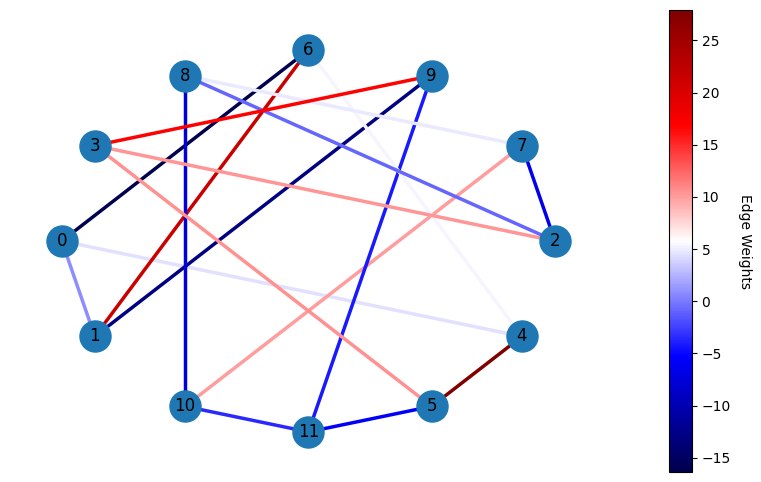

In [74]:

# Define problem size
n = 12

sigma=10


# Define 3wR graph and plot it
g = random_k_regular_graph_normal_distribution(degree=3, nodes=range(n), seed=2, weighted=True, mu=5.0, sigma=sigma, biases=False)
plot_graph(g)

# Define te problem and translate itinto a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()

# Define Hamiltonian
#cost_hamiltonian = hamiltonian_from_graph(g)
cost_hamiltonian = maxcut_qubo.hamiltonian

# Define rest of the problem and circuit
qubit_register = range(n)
pauli_coeffs = [1]*n
mixer_hamiltonian = X_mixer_hamiltonian(n, pauli_coeffs)

# Define QAOA Circuit Parameters with p=1
circuit_params = QAOACircuitParams(cost_hamiltonian, mixer_hamiltonian, p=1)

variate_params_std = create_qaoa_variational_params(circuit_params,'standard','ramp')



Evaluate `expectation` value to construct the cost landscapes for both the parameterizations. For this purpose, we define a helper function that computes the value of each pair of angles on the grid, ($\beta_0, \gamma_0$) for StandardParams

In [75]:
analytical_energy, configuration = ground_state_hamiltonian(cost_hamiltonian)
analytical_energy

-141.01610894217382

In [78]:
gammas = np.linspace(0, 5*np.pi, 100)
betas = np.linspace(0, np.pi/2, 100)

cost_landscape_std = create_cost_landscape_std(cost_hamiltonian, gammas, betas)

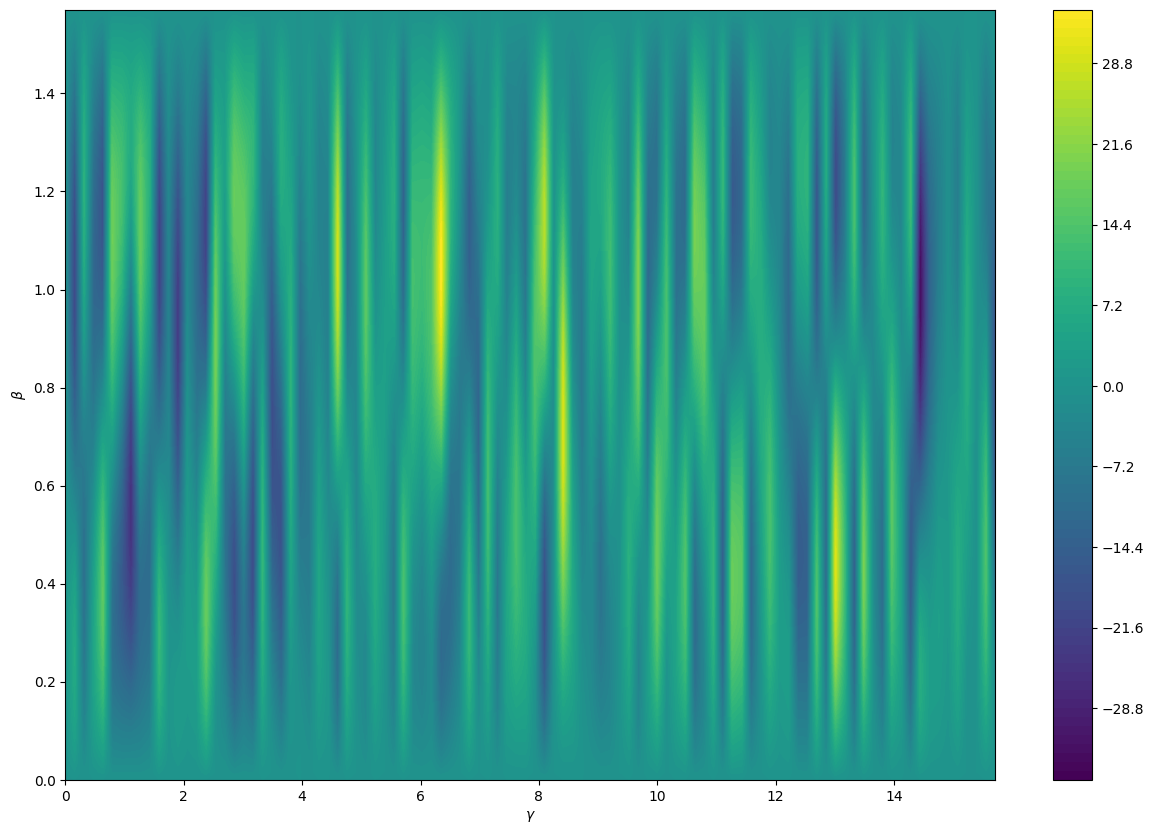

In [79]:
plt.contourf(cost_landscape_std, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

#plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.colorbar()
#plt.savefig("cost_landscape_sigma={}.png".format(sigma))
plt.show()

What are the main differences between the landscapes?

What if we rescale the Js by the largest one? How will the landscape change?

In [68]:
maxcut_qubo.weights

[-203.3789237027353,
 -23.133413613164738,
 -1063.098047834227,
 825.1354042024943,
 -891.7177925974315,
 -415.873682828102,
 256.44070857902136,
 -617.6440433036158,
 -523.9761094311694,
 -449.50380746342466,
 280.7270222732122,
 1151.104006407479,
 25.76969649920173,
 -553.9627225567584,
 274.52916029039443,
 -293.0798499032335,
 -4.565248260575737,
 592.5006097501455]

In [69]:
rescaled_weights = maxcut_qubo.weights / np.abs(np.max(maxcut_qubo.weights))
rescaled_weights

array([-0.17668162, -0.02009672, -0.92354648,  0.7168209 , -0.7746631 ,
       -0.36128246,  0.22277805, -0.53656667, -0.45519441, -0.390498  ,
        0.24387633,  1.        ,  0.02238694, -0.48124472,  0.23849206,
       -0.25460762, -0.00396597,  0.51472378])

In [70]:
terms = maxcut_qubo.terms
maxcut_qubo_rescaled = QUBO(n, terms, list(rescaled_weights))
cost_hamiltonian_rescaled = Hamiltonian.classical_hamiltonian(terms, rescaled_weights, 0)

In [71]:
analytical_energy_rescaled, configuration_rescaled = ground_state_hamiltonian(cost_hamiltonian_rescaled)
analytical_energy_rescaled

-6.4937325822219485

In [72]:
cost_landscape_std_rescaled = create_cost_landscape_std(cost_hamiltonian_rescaled, gammas, betas)

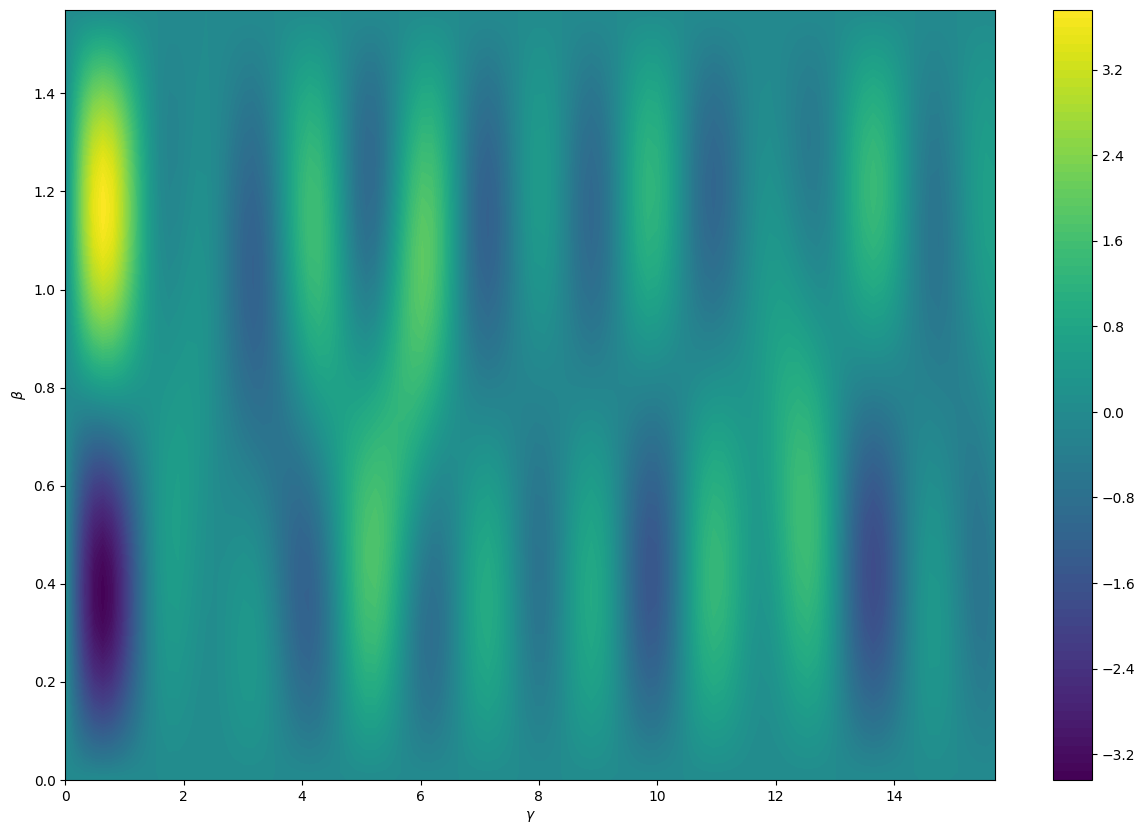

In [73]:
plt.contourf(cost_landscape_std_rescaled, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

#plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.colorbar()
plt.savefig("cost_landscape_sigma={}_rescaled.png".format(sigma))
plt.show()

### Task 2: Build script to run QAOA and solve the four instances above for a variety of optimizers (mix gradient-based and non-gradient).


In [41]:
# initialize model with default configurations
q = QAOA()

# device
qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
q.set_device(qiskit_device)

# circuit properties
q.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# backend properties (already set by default)
q.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q.set_classical_optimizer(method='cobyla', maxiter=1600, optimizer_options = {"stepsize" : 0.01},
                          optimization_progress=False, cost_progress=True, parameter_log=True)

q.compile(maxcut_qubo_rescaled) 

q.optimize()

/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


In [42]:
optimization_angles = np.array(q.results.intermediate['angles log'])
print(optimization_angles)

[[ 0.35        0.35      ]
 [ 1.35        0.35      ]
 [ 0.35        1.35      ]
 [-0.57593679 -0.02767853]
 [-0.11296839  0.16116074]
 [ 0.59258404  0.28956007]
 [ 0.34872172  0.59999673]
 [ 0.15691905  0.76034553]
 [ 0.46786633  0.63780626]
 [ 0.35725163  0.53808154]
 [ 0.2937058   0.62965308]
 [ 0.37772042  0.61164309]
 [ 0.39629185  0.63677603]
 [ 0.42201412  0.61902984]
 [ 0.38426142  0.64674645]
 [ 0.37429309  0.65877862]
 [ 0.38924663  0.65276167]
 [ 0.36870255  0.64531041]
 [ 0.38668773  0.65417263]
 [ 0.38697077  0.64393252]
 [ 0.38110358  0.64444713]
 [ 0.37730419  0.64353971]
 [ 0.38204883  0.64273797]
 [ 0.38186093  0.64079391]
 [ 0.38359943  0.63990379]
 [ 0.38317593  0.63902383]
 [ 0.38277071  0.63813531]
 [ 0.3836159   0.63881208]
 [ 0.38220107  0.63896606]
 [ 0.38207577  0.63993455]
 [ 0.38165498  0.63815646]
 [ 0.38192803  0.63856126]
 [ 0.38244513  0.63895982]
 [ 0.38260052  0.63914813]
 [ 0.38282674  0.63905632]
 [ 0.38256019  0.63923964]
 [ 0.38260594  0.6392598 ]
 

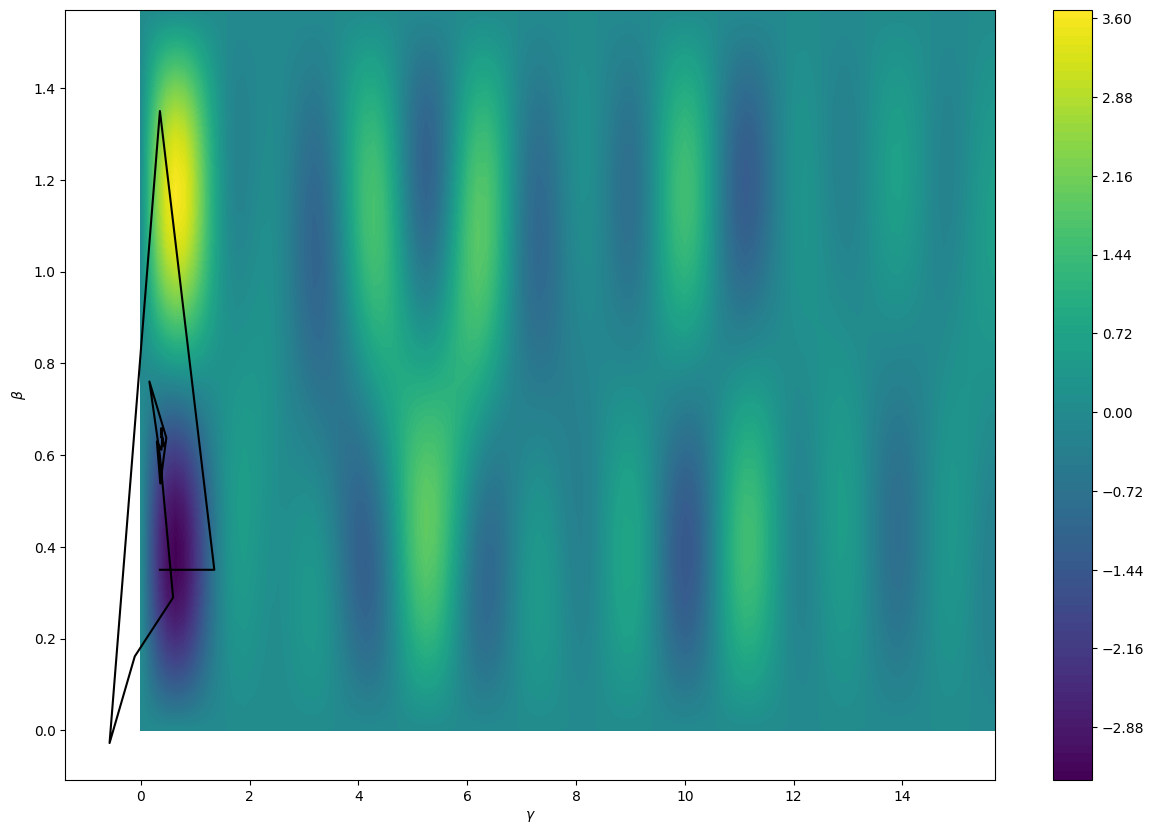

In [40]:
plt.contourf(cost_landscape_std_rescaled, cmap='viridis', levels=100, extent=(gammas[0],gammas[-1],betas[0],betas[-1]))

#plt.title(r'Cost Landscape for Standard Parameterization for $\sigma$={}'.format(sigma))
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.colorbar()
#plt.savefig("cost_landscape_sigma={}.png".format(sigma))


plt.plot(optimization_angles[:, 0], optimization_angles[:, 1], '-', color='black',  )  


plt.show()

In [44]:
q.results.intermediate['intermediate cost'][-1]

-8.115938203279192

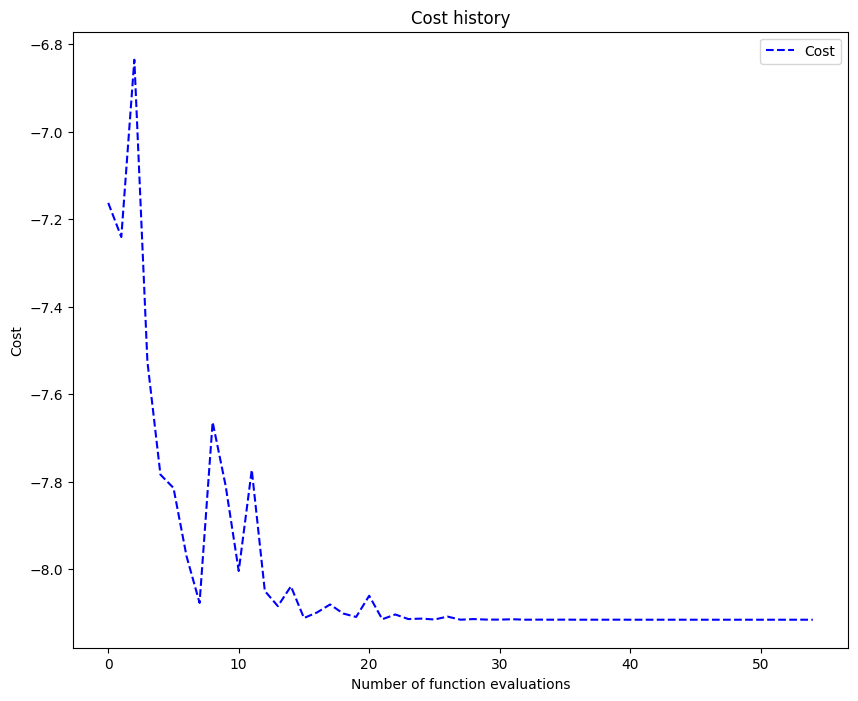

In [38]:
q.results.plot_cost()


In [42]:
q.results.most_probable_states['bitstring_energy']

-15.252028050261698

Use the QAOA result object to extract the optimization trajectories and plot them on the analytical landscapes

### Task 3: Use ground_state_hamiltonian() function from OQ to obtain the exact solution to the instances

In [39]:
# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(cost_hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -15.252028050261698, Solution: ['100111011100', '011000100011']
